In [1]:
import re
import pickle

import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

from kn import KnowledgeNeurons
from metrics import EM_compute, has_answer

In [2]:
ds = load_dataset("coastalcph/pararel_patterns")['train'].select(range(1000)).to_pandas()
tokenizer = AutoTokenizer.from_pretrained("/share/nlp/chitchat/models/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("/share/nlp/chitchat/models/Llama-3.1-8B-Instruct")
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [3]:
# ds.head()

In [4]:
kn_finder = KnowledgeNeurons(model, tokenizer)
layer_idx = 28
adaptive_threshold = 0.3

In [5]:
neurons_counts = []
answers = []

for _, row in tqdm(ds.iterrows(), total=len(ds)):
    ground_truth = row["object"]
    
    original_prompt = tokenizer.apply_chat_template([
        {"role": "user", "content": f"Answer the question in one word: {row['query']}"}, 
    ], tokenize=False, add_generation_prompt=True)

    kn_orig, answer = kn_finder.get_coarse_neurons(
        original_prompt, 
        ground_truth, 
        layer_idx=layer_idx, 
        adaptive_threshold=adaptive_threshold
    )
    neurons_counts.append(kn_orig)
    answers.append(answer)
ds['answer'] = answers
ds['is_correct'] = (ds['object'] == ds['answer']).astype(int)
ds['neurons_count'] = list(map(len, neurons_counts))
ds['neurons'] = neurons_counts
ds.to_csv('neurons_up_proj.csv')
# ds = pd.read_csv('unique_targets_neurons.csv')
# ds2 = pd.read_csv('neurons.csv')
# ds3 = pd.read_csv('opera_neurons.csv')
# ds = pd.concat([ds, ds2, ds3])

100%|██████████| 1000/1000 [1:06:17<00:00,  3.98s/it]


In [6]:
ds = load_dataset("coastalcph/pararel_patterns")['train'].to_pandas()
ds = ds[ds['object'].isin(['fruit', 'computer', 'software', 'opera', 'Dodge', 'physiology'])]
neurons_counts = []
answers = []

for _, row in tqdm(ds.iterrows(), total=len(ds)):
    ground_truth = row["object"]
    
    original_prompt = tokenizer.apply_chat_template([
        {"role": "user", "content": f"Answer the question in one word: {row['query']}"}, 
    ], tokenize=False, add_generation_prompt=True)

    kn_orig, answer = kn_finder.get_coarse_neurons(
        original_prompt, 
        ground_truth, 
        layer_idx=layer_idx, 
        adaptive_threshold=adaptive_threshold
    )
    neurons_counts.append(kn_orig)
    answers.append(answer)
ds['answer'] = answers
ds['is_correct'] = (ds['object'] == ds['answer']).astype(int)
ds['neurons_count'] = list(map(len, neurons_counts))
ds['neurons'] = neurons_counts
ds.to_csv('opera_neurons_up_proj.csv')

100%|██████████| 932/932 [48:37<00:00,  3.13s/it]  


In [7]:
ds = load_dataset("coastalcph/pararel_patterns")['train'].to_pandas()
ds = ds.drop_duplicates(subset='object')
neurons_counts = []
answers = []

for _, row in tqdm(ds.iterrows(), total=len(ds)):
    ground_truth = row["object"]
    
    original_prompt = tokenizer.apply_chat_template([
        {"role": "user", "content": f"Answer the question in one word: {row['query']}"}, 
    ], tokenize=False, add_generation_prompt=True)

    kn_orig, answer = kn_finder.get_coarse_neurons(
        original_prompt, 
        ground_truth, 
        layer_idx=layer_idx, 
        adaptive_threshold=adaptive_threshold
    )
    neurons_counts.append(kn_orig)
    answers.append(answer)
ds['answer'] = answers
ds['is_correct'] = (ds['object'] == ds['answer']).astype(int)
ds['neurons_count'] = list(map(len, neurons_counts))
ds['neurons'] = neurons_counts
ds.to_csv('unique_targets_neurons_up_proj.csv')

100%|██████████| 1847/1847 [1:39:59<00:00,  3.25s/it]


In [13]:
ds['is_correct'].value_counts()

is_correct
0    2907
1     872
Name: count, dtype: int64

In [27]:
# ds['answer'] = answers
# ds['is_correct'] = (ds['object'] == ds['answer']).astype(int)
# ds['neurons_count'] = list(map(len, neurons_counts))
# ds['neurons'] = neurons_counts

In [28]:
# ds.to_csv('unique_targets_neurons.csv', index=False)

In [29]:
# from collections import Counter
# import matplotlib.pyplot as plt

# unique_objects = ds["object"].unique()

# results = {}
# for obj in unique_objects:
#     subset = ds[ds["object"] == obj]
    
#     all_neurons = []
#     for neurons_list in subset["neurons"]:
#         all_neurons.extend(neurons_list)
    
#     counter = Counter(all_neurons)
#     top_neurons = counter.most_common(10)
#     results[obj] = top_neurons
    
#     if top_neurons:
#         labels, counts = zip(*top_neurons)
#         plt.figure(figsize=(8, 4))
#         plt.bar([str(label) for label in labels], counts, color="skyblue")
#         plt.title(f"Top 10 neurons for target: {obj} (shape: {subset.shape[0]})")
#         plt.xlabel("Neuron index")
#         plt.ylabel("Frequency")
#         plt.show()

In [12]:
ds = pd.read_csv('unique_targets_neurons.csv')
ds2 = pd.read_csv('neurons.csv')
ds3 = pd.read_csv('opera_neurons.csv')
ds = pd.concat([ds, ds2, ds3])
ds['is_correct'] = ds.apply(lambda row: has_answer([row['object']], row['answer']), axis=1)

/tmp/ipykernel_3027883/2447594694.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_correct", y="neurons_count", data=ds, palette="Set2")


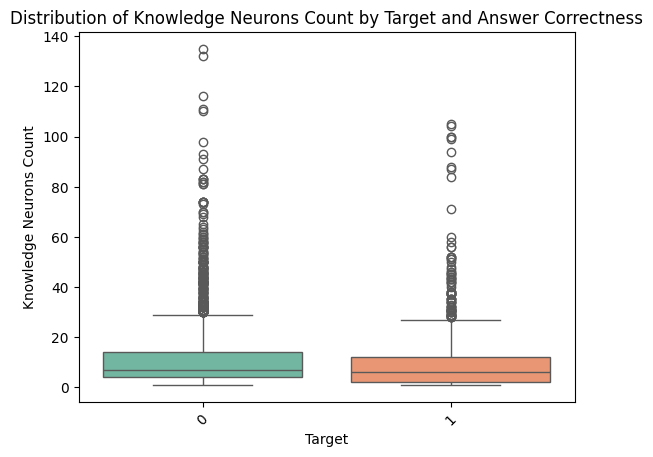

In [13]:
sns.boxplot(x="is_correct", y="neurons_count", data=ds, palette="Set2")
plt.title("Distribution of Knowledge Neurons Count by Target and Answer Correctness")
plt.xlabel("Target")
plt.ylabel("Knowledge Neurons Count")
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='neurons_count', ylabel='Count'>

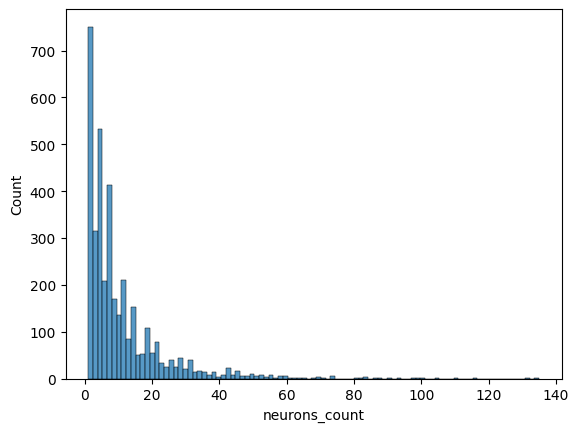

In [14]:
sns.histplot(ds['neurons_count'])

In [15]:
corr = ds['is_correct'].corr(ds['neurons_count'], method='spearman')
corr

-0.10470913909403073

In [6]:
# system = """
# Rephrase query with structure: Object, relation. 
# For example: 
# [X] is located in
# [X] owner
# Avoid any comments. Write only rephrased query. Do not repeat the original query.
# """

# def rephrase_query(original_query: str) -> str:
#     prompt = f"Rephrase the following question in a similar style: '{original_query}'"
#     prompt = tokenizer.apply_chat_template([
#         {"role": "user", "content": prompt}, 
#         {"role": "system", "content": system}
#     ], 
#         tokenize=False, add_generation_prompt=True
#     )
#     inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
#     outputs = model.generate(inputs, max_new_tokens=20)
#     rephrased = tokenizer.decode(outputs[0], skip_special_tokens=True)

#     match = re.search(r'assistant\n\n(.*)', rephrased, re.DOTALL)
#     rephrased = match.group(1).strip() if match else original_query
#     return rephrased.strip()

# # Niger is located in -> Niger is situated in
# # Pershing Center owner -> Centennial Park Stadium is owned by

In [6]:
# knowledge_flags = []
# answer_flags = [] 

# for _, row in ds.iterrows():
#     ground_truth = row["object"]
    
#     original_prompt = tokenizer.apply_chat_template([
#         {"role": "user", "content": f"Answer the question in one word: {row['query']}"}, 
#     ], tokenize=False, add_generation_prompt=True)

#     rephrased_prompt = tokenizer.apply_chat_template([
#         {"role": "user", "content": f"Answer the question in one word: {rephrase_query(row['query'])}"}, 
#     ], tokenize=False, add_generation_prompt=True)
    
#     kn_orig, answer = kn_finder.get_coarse_neurons(
#         original_prompt, 
#         ground_truth, 
#         layer_idx=layer_idx, 
#         adaptive_threshold=adaptive_threshold
#     )

#     kn_rephrased, rephrased_answer = kn_finder.get_coarse_neurons(
#         rephrased_prompt, 
#         ground_truth, 
#         layer_idx=layer_idx, 
#         adaptive_threshold=adaptive_threshold
#     )
#     print('here')
#     print(kn_orig)
#     print(kn_rephrased)
#     common_kn = set(kn_orig).intersection(set(kn_rephrased))
#     knowledge_flag = 1 if len(common_kn) >= 2 else 0
#     knowledge_flags.append(knowledge_flag)
    
#     print(ground_truth)
#     print(answer)
#     answer_flag = 1 if EM_compute([ground_truth], answer) else 0
#     answer_flags.append(answer_flag)